In [5]:
import time
from collections import defaultdict
import json
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'  # https://stackoverflow.com/questions/34387893/output-matplotlib-figure-to-svg-with-text-as-text-not-curves
plt.style.use('seaborn-ticks')

import seaborn as sns
import dateutil
from scipy.stats import spearmanr, pearsonr, kendalltau
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, fcluster, fclusterdata

from sklearn.cross_decomposition import PLSRegression, CCA
from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import (
    cross_val_score, cross_val_predict,
    RepeatedKFold, RepeatedStratifiedKFold,
    train_test_split, 
    GridSearchCV,
)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay,
    f1_score, 
    recall_score,
    accuracy_score,
    precision_score, precision_recall_curve, precision_recall_fscore_support,
    #     plot_roc_curve,
    #     plot_precision_recall_curve,  ## The plot_x_score API is deprecated
)
import sklearn
print(sklearn.__version__)

1.0.2


In [2]:
# colors
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)
    
animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic = [1076, 1082, 1101]
impaired = [1060, 1062, 1074, 1092, 1102]
normal = [1091, 1093]

obs = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='cleaned')
obs['animal'] = obs['animal'].str.strip('TM').astype('int')
obs['datetime'] = obs['when'].apply(dateutil.parser.parse)
animal_phenotypes = pd.read_excel(r'..\data\metadata\20210421_FBGRBGOGTT_Huishi sample sheet.xlsx', sheet_name='animal phenotypes')
animal_phenotypes['animal'] = animal_phenotypes['animal'].str.strip('TM').astype('int')

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [3]:
X_all = data[data_cols].T
X_only_conv = data.loc[~data[pval_cols].isna().all(axis=1), data_cols].T
gluc_tol_cols = ['fdr corrected pval effect of glucose tolerance', 
                 'fdr corrected pval effect of interaction sampling and glucose tolerance']
X_only_signf = data.loc[(data[gluc_tol_cols] < 0.05).any(axis=1), data_cols].T


y_3class = fg.set_index('combined_col_name')['glucose_tolerance']         # ['normal', 'impaired', 'diabetic']
y_3class_num = y_3class.map({'normal': 0, 'impaired': 1, 'diabetic': 2})  # [0, 1, 2]
y_bg = fg.set_index('combined_col_name')['bg']                            # random/fasted blood glucoose
ogtt_dict = animal_phenotypes.set_index('animal').to_dict()['OGTT (AUC)'] # OGTT AUC
y_ogtt = fg[['combined_col_name', 'animal']].set_index('combined_col_name')['animal'].map(ogtt_dict)  

# PLS Regression is supervised regression. PLS-DA is the extension into classification

## Good examples
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html#sphx-glr-auto-examples-cross-decomposition-plot-pcr-vs-pls-py
https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_compare_cross_decomposition.html#sphx-glr-auto-examples-cross-decomposition-plot-compare-cross-decomposition-py

# In general, you do not need to center or standardize X for multiple regression: 
https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia



In [139]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_ogtt, test_size=0.1, random_state=1)

pls = PLSRegression(n_components=20).fit(X_all, y_ogtt)
cca = CCA(n_components=1).fit(X_all, y_ogtt)

pls.coef_
cca.coef_

array([[ -5.57863638],
       [ -2.91450087],
       [ -1.73222946],
       ...,
       [-14.18323624],
       [-10.03314674],
       [-20.18829183]])

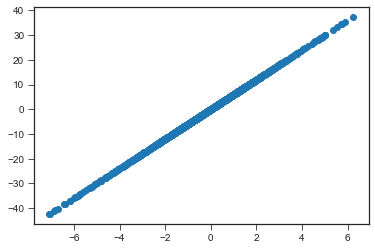

In [140]:
plt.scatter(pls.coef_, cca.coef_)

In [112]:
data.index

Index(['l_0', 'l_1', 'l_2', 'l_3', 'l_4', 'l_5', 'l_6', 'l_7', 'l_8', 'l_9',
       ...
       'm_682', 'm_368', 'm_340', 'm_616', 'm_557', 'm_169', 'm_213', 'm_24',
       'm_505', 'm_441'],
      dtype='object', name='i', length=1727)

In [138]:
coefs = pd.DataFrame({'pls': pls.coef_[:, 0], 'cca': cca.coef_[:, 0]}, index=data.index)
display(coefs)
coefs.to_csv(r'..\data\processed\PLS_CCA_coefficients.csv')

,pls,cca
i,,
l_0,-0.931551,-0.931551
l_1,-0.486782,-0.486782
l_2,-0.288953,-0.288953
l_3,-3.575051,-3.575051
l_4,-0.895787,-0.895787
...,...,...
m_169,-4.979228,-4.979228
m_213,-1.370114,-1.370114
m_24,-2.367655,-2.367655


In [75]:
pls.x_scores_.shape

(60, 10)

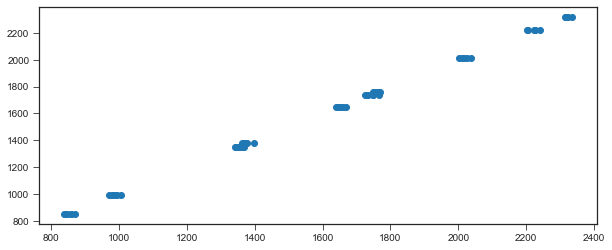

In [78]:
plt.scatter(pls.predict(X_all), y_ogtt)
plt.gcf().set_size_inches(10, 4)

In [73]:
pls.x_weights_.shape

(1727, 10)

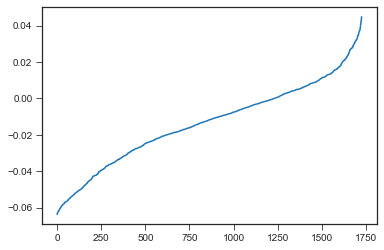

In [82]:
plt.plot(range(1727), np.sort(pls.x_loadings_[:, 0]))

In [95]:
pls.y_scores_.shape

(60, 10)

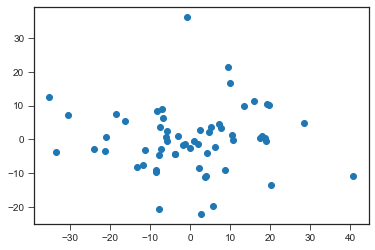

In [93]:
plt.scatter(pls.x_scores_[:, 0], pls.x_scores_[:, 1])

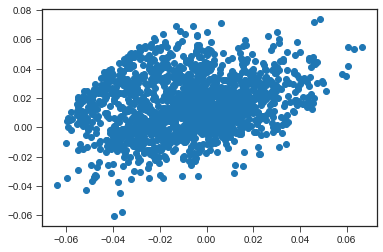

In [109]:
plt.scatter(pls.x_weights_[:, 0], pls.x_weights_[:, 1])